#SVM

## Load dataset

In [2]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC, LinearSVC
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

from collections import defaultdict
from scipy.stats.stats import pearsonr

In [3]:
customers = pd.read_csv('/content/drive/MyDrive/DM/Classification/normalized_data_classification_training_tot.csv', sep=',', index_col=0) 

In [4]:
customers_test = pd.read_csv('/content/drive/MyDrive/DM/Classification/normalized_data_classification_test_tot.csv', sep=',', index_col=0) 

In [5]:
customers.describe()

,NumBaskets_mean,DistinticProducts_mean,Qta_mean,Sale_mean,Qta_entropy,Sale_entropy,label
count,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000,3311.000000
mean,0.057735,0.120153,0.207445,0.141933,0.501611,0.734843,1.017517
std,0.117653,0.107006,0.161356,0.120196,0.222969,0.241579,0.725659
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.048138,0.091837,0.057230,0.388729,0.628275,0.000000
50%,0.000000,0.092643,0.165816,0.110778,0.544568,0.812482,1.000000
75%,0.070588,0.160763,0.281144,0.196253,0.639243,0.908394,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [6]:
customers.head()

,NumBaskets_mean,DistinticProducts_mean,Qta_mean,Sale_mean,Qta_entropy,Sale_entropy,label
0,0.000000,0.121448,0.321975,0.129797,0.417977,0.894589,2
1,0.000000,0.005450,0.058248,0.002189,0.000000,0.000000,0
2,0.000000,0.354223,0.674745,0.574020,0.562301,0.934952,2
3,0.000000,0.081744,0.248724,0.054193,0.212806,0.623800,1
4,0.264706,0.083106,0.166454,0.169366,0.336874,0.844006,1


In [7]:
x_training = customers[["NumBaskets_mean", "DistinticProducts_mean", "Qta_mean", "Qta_entropy", "Sale_mean", "Sale_entropy"]].to_numpy()
y_training = customers["label"].to_numpy()

In [8]:
x_test = customers_test[["NumBaskets_mean", "DistinticProducts_mean", "Qta_mean", "Qta_entropy", "Sale_mean", "Sale_entropy"]].to_numpy()
y_test = customers_test["label"].to_numpy()

## GridSearch and Cross Validation setup

In [9]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_training),
                                                 y_training)

In [10]:
class_weights_dict = {}
for i in range(len(class_weights)):
  class_weights_dict[i] = class_weights[i]

In [11]:
grid_params = {
    "kernel": ["rbf", "poly", "sigmoid"],
    "C": [0.01, 0.1, 1, 2, 4, 8],
    "gamma": ["scale", 0.01, 0.1, 16, 32]
}

In [12]:
cv = StratifiedKFold(n_splits = 5, random_state = 1234, shuffle=True)

In [13]:
grid_search = GridSearchCV(
    SVC(class_weight=class_weights_dict, probability=True, decision_function_shape='ovo'),
    grid_params,
    verbose = 1,
    cv = cv,
    scoring='f1_weighted',
    n_jobs=4,
    return_train_score=True
)

In [ ]:
grid_search.fit(x_training, y_training)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  4.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1234, shuffle=True),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight={0: 1.3092131277184658,
                                         1: 0.7043182301637949,
                                         2: 1.2249352571217167},
                           coef0=0.0, decision_function_shape='ovo', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=4,
             param_grid={'C': [1, 2, 4], 'gamma': [16], 'kernel': ['poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='f1_weighted', verbose=1)

In [ ]:
print('Best setting parameters ', grid_search.best_params_)
print('Mean and std of this setting ', grid_search.best_score_)

Best setting parameters  {'C': 1, 'gamma': 16, 'kernel': 'poly'}
Mean and std of this setting  0.8902304499275537


## Results evaluation

In [14]:
def plot_confusion_matrix(y_true,y_pred,filename):
  matrix = confusion_matrix(y_true,y_pred,labels = [0,1,2])
  names = ['Low Spend','Medium Spend', 'High Spend']
  row,column = matrix.shape
  values = []
  for i in range(row):
    single_row_values = []
    for j in range(column):
      single_row_values.append(matrix[i,j]/len(y_true))
    values.append(single_row_values)
  df_cm = pd.DataFrame(matrix, index = names, columns = names)
  plt.figure(figsize = (10,7))
  ax = sn.heatmap(df_cm, annot=values,fmt='.4f',cmap='viridis',cbar = False,square = True)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('True')
  ax.xaxis.set_label_position('top') 
  plt.savefig(filename + '.png')

Classification Report [TR]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       843
           1       0.93      0.85      0.89      1567
           2       0.92      0.94      0.93       901

    accuracy                           0.90      3311
   macro avg       0.90      0.91      0.90      3311
weighted avg       0.90      0.90      0.90      3311



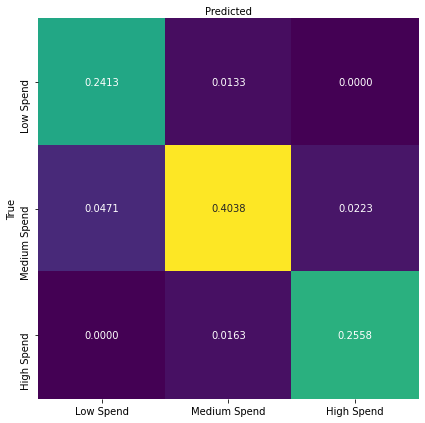

Classification Report [TS]
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       211
           1       0.91      0.81      0.85       392
           2       0.86      0.92      0.89       232

    accuracy                           0.87       835
   macro avg       0.86      0.89      0.87       835
weighted avg       0.87      0.87      0.87       835



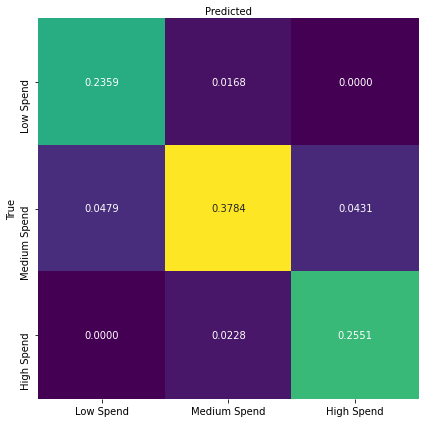

In [15]:
best_estimator = SVC(C=1, break_ties=False, cache_size=200,
    class_weight={0: 1.3092131277184658, 1: 0.7043182301637949,
                  2: 1.2249352571217167},
    coef0=0.0, decision_function_shape='ovo', degree=3, gamma=16, kernel='poly',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
best_estimator.fit(x_training, y_training)
y_tr_predict = best_estimator.predict(x_training)
y_ts_predict = best_estimator.predict(x_test)
print("Classification Report [TR]")
print(classification_report(y_training, y_tr_predict))
plot_confusion_matrix(y_training, y_tr_predict, "/content/drive/MyDrive/DM/Classification/SVM/confusion_matrix_train")
#"/content/drive/MyDrive/DM/Classification/SVM/confusion_matrix_train"
plt.show() 
print("Classification Report [TS]")
print(classification_report(y_test, y_ts_predict))
plot_confusion_matrix(y_test, y_ts_predict, '/content/drive/MyDrive/DM/Classification/SVM/confusion_matrix_test')
#"/content/drive/MyDrive/DM/Classification/SVM/confusion_matrix_test"

plt.show() 